In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.preprocessing import (
    load_data,
    resize_grid
)
from src.cosine_weighting import (
    compute_weighted_ghg,
    compute_weighted_average_latitude_bands
)

In [2]:
year_min = 2002
year_max = 2022
gas = "ch4"
path_obs4mips = f"../data/OBS4MIPS_{gas.upper()}.csv"
path_cmip7 = f"../data/CMIP7_{gas.upper()}.csv"

df_obs4mips = load_data(path_obs4mips, year_min=year_min, year_max=year_max)
df_cmip7 = load_data(path_cmip7, year_min=year_min, year_max=year_max)

Minimum year available in dataset is 2003 and will be used as year_min.


Background OBS4MIPS

+ XCO2_OBS4MIPS and XCH4_OBS4MIPS data products have been obtained by gridding (averaging) the version 4.1 L2 products (EMMA) using monthly time and $5^\circ \times 5^\circ$ spatial resolution
+ XCO2 is the column-averaged dry-air mixing ratio (mole fraction) of atmospheric $CO_2$
    + unit: mol/mol -> factor: 1e6 (to get ppm)
+ XCH4 is the column-averaged dry-air mixing ratio (mole fraction) of atmospheric $CH_4$
    + unit: mol/mol -> factor: 1e9 (to get ppb)
    +  XCH4 is typically somewhat higher over the northern hemisphere, as most methane sources are located in the northern hemisphere
+ Due to the gridding / averaging process needed to generate Obs4MIPs products detailed time/location information is not available in the Obs4MIPs data product.
+ A filtering procedure has been applied to remove “unreliable” grid cells considering the overall noise error (12 ppb / 1.6 ppm) and total uncertainty (14 ppb / 1.8 ppm) of each cell

*References*
+ [Product Quality Assessment Report](https://www.iup.uni-bremen.de/carbon_ghg/docs/C3S/CDR3_2003-2018/PQAR/C3S_D312b_Lot2.2.3.2-v1.0_PQAR-GHG_MAIN_v3.1.pdf)
+ [Ensemble-based satellite-derived carbon dioxide and methane column-averaged dry-air mole fraction data sets (2003–2018) for carbon and climate applications](https://amt.copernicus.org/articles/13/789/2020/)
+ [Product User Guide Specification - Annex D](http://wdc.dlr.de/C3S_312b_Lot2/Documentation/GHG/C3S2_312a_Lot2_PUGS_GHG_D_latest.pdf)
+ [ESA Greenhouse Gases Climate Change Initiative (GHG-CCI): Merged SCIAMACHY and GOSAT Level 3 gridded atmospheric column-average methane (XCH4) product in Obs4MIPs format version 2](https://figshare.le.ac.uk/articles/conference_contribution/The_GHG-CCI_project_of_ESA_s_climate_change_initiative_Data_products_and_application/10230590/1/files/18458306.pdf)
+ [Technical Document XCH4](https://dap.ceda.ac.uk/neodc/esacci/ghg/docs/obs4mips/TechNote_SCIAGOSAT_L3_CRDP3_001_XCH4_FINAL.pdf)
+ [Technical Document XCO2](https://dap.ceda.ac.uk/neodc/esacci/ghg/docs/obs4mips/TechNote_SCIAGOSAT_L3_CRDP3_001_XCO2_FINAL.pdf)

In [3]:
df_obs4mips.head()

,time,bnds,lat,lon,pressure,time_bnds,lat_bnds,lon_bnds,pre,pre_bnds,land_fraction,xch4,xch4_nobs,xch4_stderr,xch4_stddev,column_averaging_kernel,vmr_profile_ch4_apriori,year,month,day
0,2003-01-16 12:00:00,0,-87.5,-177.5,0,2003-01-01,-90.0,-180.0,0.95,1.0,0.998163,1.000000e+20,NaN,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,2003,1,16
1,2003-01-16 12:00:00,0,-87.5,-177.5,1,2003-01-01,-90.0,-180.0,0.85,0.9,0.998163,1.000000e+20,NaN,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,2003,1,16
2,2003-01-16 12:00:00,0,-87.5,-177.5,2,2003-01-01,-90.0,-180.0,0.75,0.8,0.998163,1.000000e+20,NaN,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,2003,1,16
3,2003-01-16 12:00:00,0,-87.5,-177.5,3,2003-01-01,-90.0,-180.0,0.65,0.7,0.998163,1.000000e+20,NaN,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,2003,1,16
4,2003-01-16 12:00:00,0,-87.5,-177.5,4,2003-01-01,-90.0,-180.0,0.55,0.6,0.998163,1.000000e+20,NaN,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,2003,1,16


In [4]:
df_cmip7.head()

,time,lat,bnds,ch4,time_bnds,lat_bnds,year,month,day
576288,2002-01-15,-82.5,0,1714.2593,2002-01-01 00:00:00,-90.0,2002,1,15
576289,2002-01-15,-82.5,1,1714.2593,2002-02-01 00:00:00,-75.0,2002,1,15
576290,2002-01-15,-67.5,0,1714.9755,2002-01-01 00:00:00,-75.0,2002,1,15
576291,2002-01-15,-67.5,1,1714.9755,2002-02-01 00:00:00,-60.0,2002,1,15
576292,2002-01-15,-52.5,0,1716.3290,2002-01-01 00:00:00,-60.0,2002,1,15


In [5]:
# compare latitudinal bands
print("cmip7: lat_bnds")
print(df_cmip7.lat_bnds.unique())
print("obs4mips: lat_bnds")
print(df_obs4mips.lat_bnds.unique())

print("obs4mips: lon_bnds")
print(df_obs4mips.lon_bnds.unique())
print(len(df_obs4mips.lon_bnds.unique()))

cmip7: lat_bnds
[-90. -75. -60. -45. -30. -15.   0.  15.  30.  45.  60.  75.  90.]
obs4mips: lat_bnds
[-90. -85. -80. -75. -70. -65. -60. -55. -50. -45. -40. -35. -30. -25.
 -20. -15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.
  50.  55.  60.  65.  70.  75.  80.  85.  90.]
obs4mips: lon_bnds
[-180. -175. -170. -165. -160. -155. -150. -145. -140. -135. -130. -125.
 -120. -115. -110. -105. -100.  -95.  -90.  -85.  -80.  -75.  -70.  -65.
  -60.  -55.  -50.  -45.  -40.  -35.  -30.  -25.  -20.  -15.  -10.   -5.
    0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175.
  180.]
73


In [6]:
print("obs4mips: lat \n", df_obs4mips.lat.unique())

obs4mips: lat 
 [-87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5 -37.5 -32.5
 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5  22.5  27.5
  32.5  37.5  42.5  47.5  52.5  57.5  62.5  67.5  72.5  77.5  82.5  87.5]


In [7]:
# how many months do we have with missing values (in total)?
df_obs4mips[df_obs4mips[f"x{gas}"] == 1e20].time.unique().shape

(240,)

[]

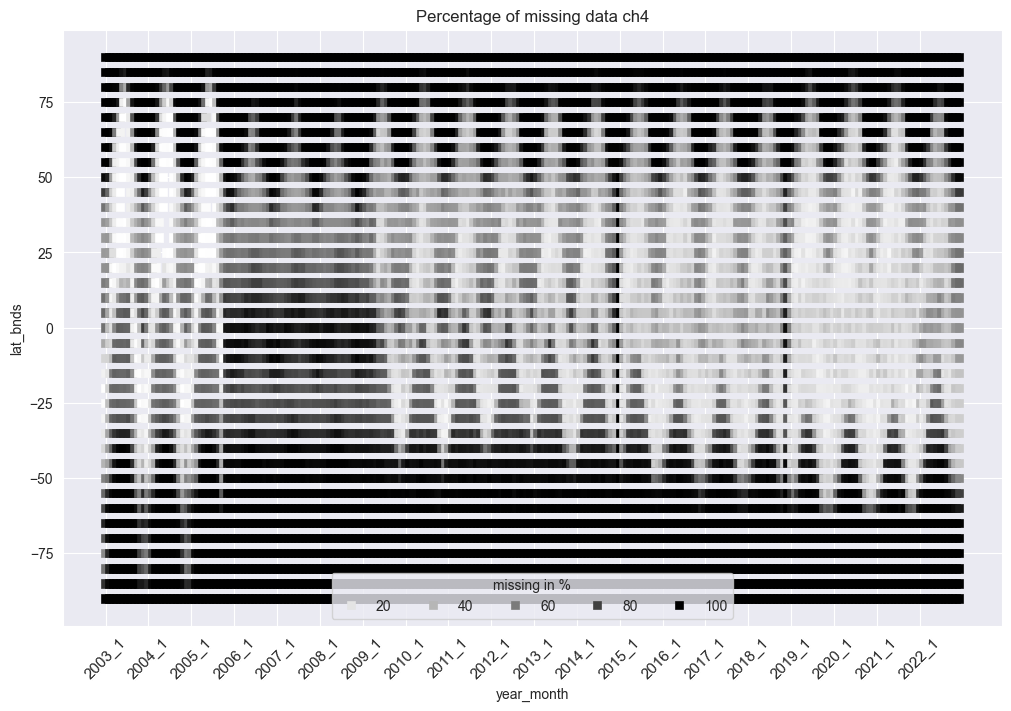

In [8]:
# percentage of missing data per month-year
missing = pd.DataFrame(
    np.round(
        np.divide(
            df_obs4mips[df_obs4mips[f"x{gas}"] == 1e20].groupby(["year", "month", "lat_bnds"]).agg({f"x{gas}": "count"})[f"x{gas}"],
            df_obs4mips.groupby(["year", "month", "lat_bnds"]).agg({f"x{gas}": "count"})[f"x{gas}"]
        )*100, decimals=2
    )
).reset_index()

missing["year_month"] = missing["year"].astype(str)+"_"+missing["month"].astype(str)

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10,7))
sns.scatterplot(
    data=missing, x="year_month", y="lat_bnds", hue=f"x{gas}", marker="s",
    edgecolor=None, ax=axs, palette="Greys",
)
ticks = axs.get_xticks()
axs.set_xticks(ticks[::12])
plt.xticks(size=11, rotation=45)
plt.title(f"Percentage of missing data {gas}")
plt.legend(title="missing in %", loc="lower center", ncol=5)
plt.plot()

### Working with earth grids

+ we are interested in latitudinal bands
+ as the geometry of grid cells changes depending on where we are on a sphere we have to adjust for it
+ the area of a grid cell can be approximated via:
$$
A = R^2 \cdot (\lambda_2 - \lambda_1) \cdot (\sin(\phi_2) - \sin(\phi_1))
$$
with $R$ being the radius of the sphere, and $\lambda$, $\phi$ the bounding geocentric longitudes and latitudes.
[Reference](https://onlinelibrary.wiley.com/doi/epdf/10.1111/tgis.12636)
+ Notation:
    + $j^{th}$ longitude with $\lambda_j$ with $j = 1, \ldots, M$
    + $i^{th}$ latitude with $i=1,\ldots,N$
    + $x_{ij}$ observation at lon $j$ and lat $i$

$$
\tilde{x}_{ij} = \underbrace{R^2 \cdot \Delta\lambda_j \cdot \Delta\phi_i}_{w_{ij}} \cdot x_{ij}
$$
+ the grid of the OBS4MIPS data is a $5^\circ \times 5^\circ$ grid of the following form

<img src="../figures/5by5_grid.jpg" width="300">

+ we are interested in latitudinal bands, thus we average for each latitude over the longitudes

<img src="../figures/earth_grid1.jpg" width="300">

+ note that $\Delta \lambda_j = 5.$ and $R$ are constant, therefore averaging over the longitudes is equivalent to taking an unweighted average
$$
\tilde{x}'_i = \frac{R^2 \cdot \sum_j^M 5 \cdot x_{ij}}{R^2 \sum_j^M 5}=\frac{R^2 \cdot 5 \cdot \sum_j^M x_{ij}}{R^2 \cdot 5 \cdot M}  =\frac{\sum_j^M x_{ij}}{M}
$$

<img src="../figures/grid_cells.jpg" width="300">

+ however, to get the values for a specific latitudinal band, we have to use a weighted average as $\Delta \phi_i$ changes with the bounding latitudes for each $\tilde{x}_i'$

$$
\bar{\tilde{x}} = \frac{\sum_i^N \Delta \phi_i \cdot \tilde{x}_i'}{\sum_i^N \Delta \phi_i}
$$

<img src="../figures/latitudinal_band.jpg" width="200">

**Question: How to resize the grid cells?**

+ When we do a weighted average for each latitude band, then we have already considered the geometric change in the individual cells
+ thus, I don't see a problem of simply averaging the weighted averages of each latitude band to compute the desired grid cell size

<img src="../figures/resize_grid_cells.jpg" width="150">

In [21]:
# preprocess data
if gas == "ch4":
    factor = 1e9
elif gas == "co2":
    factor = 1e6
else:
    raise ValueError(f"Unknown {gas=}")

# compute weighted ghg values (approx. geometric distortion of grid cells on sphere)
df_obs4mips_weighted = compute_weighted_ghg(
    df_obs4mips, gas=gas, unit_factor=factor, cmip_data=False, cell_size=5
)
df_cmip7_weighted = compute_weighted_ghg(
    df_cmip7, gas=gas, unit_factor=None, cmip_data=True, cell_size=15
)

# compute weighted average across latitude bands
df_obs4mips_weighted_avg = compute_weighted_average_latitude_bands(
    df_obs4mips_weighted, gas=gas
)
df_cmip7_weighted_avg = compute_weighted_average_latitude_bands(
    df_cmip7_weighted, gas=gas

)

df_obs4mips_new_grid = resize_grid(
    df_obs4mips_weighted_avg, lat_bnds_seq = [0,60], gas=gas
)
df_cmip7_new_grid = resize_grid(
    df_cmip7_weighted_avg, lat_bnds_seq =[0,60], gas=gas
)

df_obs4mips_new_grid

,year,month,day,lat_bnd,xch4_weighted_avg
0,2003.0,1.0,16.0,0-60-N,1753.821831
1,2003.0,1.0,16.0,0-60-S,1684.878211
2,2003.0,2.0,15.0,0-60-N,1743.732736
3,2003.0,2.0,15.0,0-60-S,1682.108825
4,2003.0,3.0,16.0,0-60-N,1740.780001
...,...,...,...,...,...
473,2022.0,10.0,16.0,0-60-S,1850.921077
474,2022.0,11.0,16.0,0-60-N,1913.198426
475,2022.0,11.0,16.0,0-60-S,1846.954643
476,2022.0,12.0,16.0,0-60-N,1912.389588


In [20]:
df_cmip7_new_grid.head()

,year,month,day,lat_bnd,xch4_weighted_avg,year_month
0,2002.0,1.0,15.0,0-60-N,1847.302878,2002_1
1,2002.0,1.0,15.0,0-60-S,1738.819312,2002_1
2,2002.0,2.0,15.0,0-60-N,1846.344681,2002_2
3,2002.0,2.0,15.0,0-60-S,1735.307952,2002_2
4,2002.0,3.0,15.0,0-60-N,1844.459781,2002_3
...,...,...,...,...,...,...
499,2022.0,10.0,15.0,0-60-S,1891.642984,2022_10
500,2022.0,11.0,15.0,0-60-N,1990.898811,2022_11
501,2022.0,11.0,15.0,0-60-S,1891.039036,2022_11
502,2022.0,12.0,15.0,0-60-N,1996.407874,2022_12


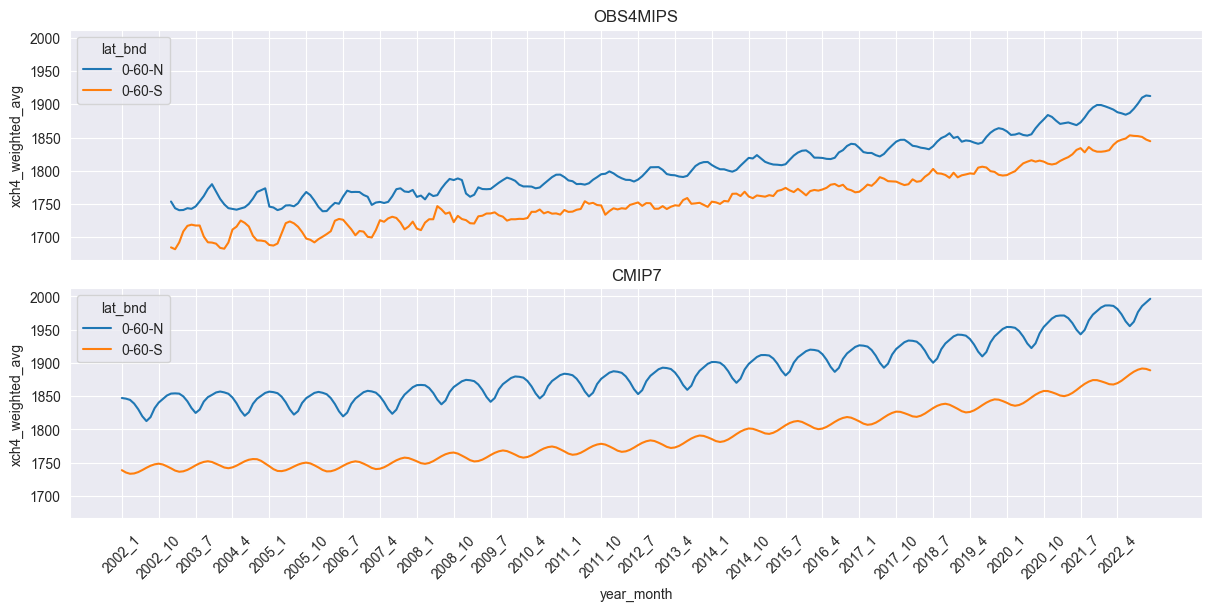

In [41]:
df_obs4mips_new_grid["year_month"] = df_obs4mips_new_grid["year"].astype(int).astype(str)+"_"+df_obs4mips_new_grid["month"].astype(int).astype(str)
df_cmip7_new_grid["year_month"] = df_cmip7_new_grid["year"].astype(int).astype(str)+"_"+df_cmip7_new_grid["month"].astype(int).astype(str)


fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(12,6),
                        sharex=True, sharey=True)
sns.lineplot(df_cmip7_new_grid, x="year_month", y=f"x{gas}_weighted_avg", hue="lat_bnd", ax=axs[1])
sns.lineplot(df_obs4mips_new_grid, x="year_month", y=f"x{gas}_weighted_avg", hue="lat_bnd", ax=axs[0])
for i in range(2):
    ticks = axs[i].get_xticks()
    axs[i].set_xticks(ticks[::3])
    axs[i].tick_params("x", size=7, rotation=45)
[axs[i].set_title(t) for i,t in enumerate(["OBS4MIPS", "CMIP7"])]
plt.show()